# **Backtrader数据加载以及自定义数据**

In [1]:
import backtrader as bt
import tushare as ts
import pandas as pd
import akshare as ak
from backtrader.feeds import PandasData
from datetime import datetime as dt
import warnings
from datetime import datetime
import quantstats as qs

import talib as ta   # 这里需要安装talib

from backtrader.feeds import GenericCSVData

warnings.filterwarnings("ignore")

In [2]:
# pip install TA-Lib

In [3]:
# import sys

# print(sys.version)
# print (sys.executable)

## **先定义一个简单的均线策略**

In [4]:
class SmaCross(bt.Strategy):
    # 定义参数
    params = dict(period=5  # 移动平均期数
                  )

    def __init__(self):
        # 移动平均线指标
        self.move_average = bt.ind.MovingAverageSimple(
            self.datas[0].close, period=self.params.period)  #self.p.period

    def next(self):
        size = int(self.broker.getvalue() / self.datas[0].close // 100 * 100)  # 股数
        if not self.position.size:  # 还没有仓位
            # 当日收盘价上穿5日均线，创建买单，全仓买入
            if self.datas[0].close[-1] < self.move_average.sma[
                -1] and self.datas[0].close[0] > self.move_average.sma[0]:
                self.buy(size=size)
        # 有仓位，并且当日收盘价下破5日均线，创建卖单，全仓卖出
        elif self.datas[0].close[-1] > self.move_average.sma[-1] and self.datas[
            0].close[0] < self.move_average.sma[0]:
            self.close()

In [5]:
start_date = '20150101'
end_date   = '20230101'
symbol     = '000001' 

## **使用Pandas作为数据源**

In [6]:
stock_zh_a_hist_df = ak.stock_zh_a_hist(symbol=symbol, period="daily", start_date=start_date, end_date=end_date, adjust="hfq")
stock_zh_a_hist_df.rename(columns={'日期':'date','开盘':'open','收盘':'close','最高':'high','最低':'low','成交量':'volume','换手率':'turnover'},inplace=True)
print(stock_zh_a_hist_df.head())
stock_zh_a_hist_df = stock_zh_a_hist_df[['date', 'open', 'high', 'low', 'close', 'volume']]
stock_zh_a_hist_df.date=pd.to_datetime(stock_zh_a_hist_df.date)
# stock_zh_a_hist_df.sort_values(by='date', inplace=True)
stock_zh_a_hist_df

         date     open    close     high      low   volume           成交额  \
0  2015-01-05  1797.18  1800.57  1829.92  1753.17  2860436  4.565388e+09   
1  2015-01-06  1781.38  1773.48  1842.33  1747.52  2166421  3.453446e+09   
2  2015-01-07  1748.65  1739.62  1779.13  1719.31  1700121  2.634796e+09   
3  2015-01-08  1741.88  1680.93  1749.78  1674.16  1407714  2.128003e+09   
4  2015-01-09  1674.16  1694.48  1783.64  1652.72  2508500  3.835378e+09   

     振幅   涨跌幅    涨跌额  turnover  
0  4.31  1.14  20.32      2.91  
1  5.27 -1.50 -27.09      2.20  
2  3.37 -1.91 -33.86      1.73  
3  4.35 -3.37 -58.69      1.43  
4  7.79  0.81  13.55      2.55  


,date,open,high,low,close,volume
0,2015-01-05,1797.18,1829.92,1753.17,1800.57,2860436
1,2015-01-06,1781.38,1842.33,1747.52,1773.48,2166421
2,2015-01-07,1748.65,1779.13,1719.31,1739.62,1700121
3,2015-01-08,1741.88,1749.78,1674.16,1680.93,1407714
4,2015-01-09,1674.16,1783.64,1652.72,1694.48,2508500
...,...,...,...,...,...,...
1942,2022-12-26,2317.14,2325.26,2271.63,2281.38,797120
1943,2022-12-27,2297.63,2354.52,2297.63,2336.64,886004
1944,2022-12-28,2344.77,2380.52,2318.76,2341.52,791192
1945,2022-12-29,2330.14,2339.89,2294.38,2323.64,666890


In [7]:
stock_data = PandasData(
                dataname=stock_zh_a_hist_df,
                datetime=0,  # 日期列
                open=1,  # 开盘价所在列
                high=2,  # 最高价所在列
                low=3,  # 最低价所在列
                close=4,  # 收盘价所在列
                volume=5,
                fromdate=dt.strptime(start_date, '%Y%m%d'),  # 起始日  dt.strptime(start, '%Y%m%d')
                todate=dt.strptime(end_date, '%Y%m%d'),  # 结束日
            )

初始市值: 1000000.00
最终市值: 1739123.00


                           Strategy
-------------------------  ----------
Start Period               2015-01-05
End Period                 2022-12-30
Risk-Free Rate             0.0%
Time in Market             58.0%

Cumulative Return          73.91%
CAGR﹪                     4.9%

Sharpe                     0.45
Prob. Sharpe Ratio         89.52%
Smart Sharpe               0.43
Sortino                    0.71
Smart Sortino              0.69
Sortino/√2                 0.5
Smart Sortino/√2           0.49
Omega                      1.12

Max Drawdown               -35.46%
Longest DD Days            816
Volatility (ann.)          20.95%
Calmar                     0.14
Skew                       0.96
Kurtosis                   10.24

Expected Daily %           0.03%
Expected Monthly %         0.58%
Expected Yearly %          7.16%
Kelly Criterion            4.94%
Risk of Ruin               0.0%
Daily Value-at-Risk        -2.13%
Expected Shortfall (cVaR)  -2.13%

Max Consecutive Wins       9


None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-02-02,2022-11-04,2022-12-30,697,-35.458351,-35.044880
2,2015-04-17,2016-02-25,2017-07-10,816,-21.039835,-19.699547
3,2017-11-23,2018-08-14,2019-02-28,463,-20.067205,-19.904511
4,2019-10-15,2020-04-03,2020-07-03,263,-14.301582,-13.394560
5,2015-01-16,2015-03-10,2015-04-07,82,-13.600000,-13.261500


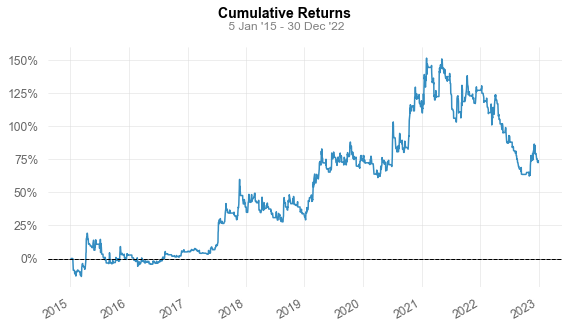

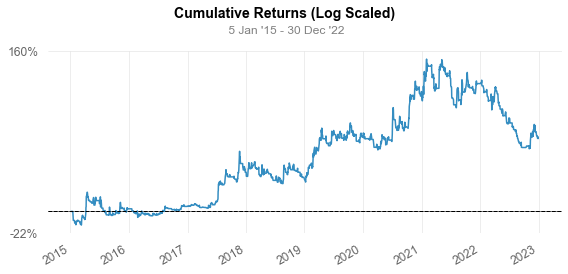

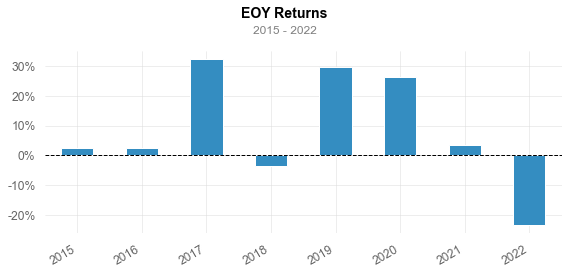

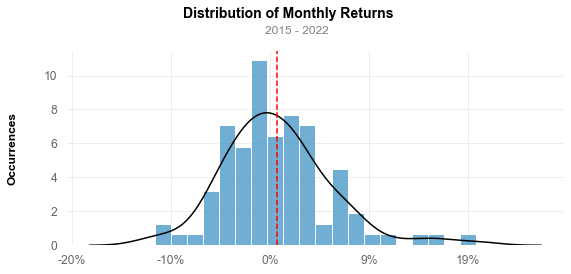

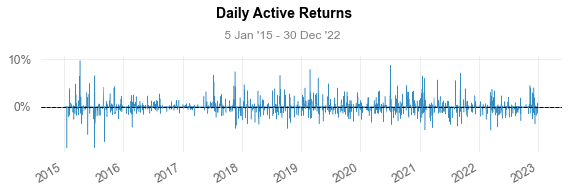

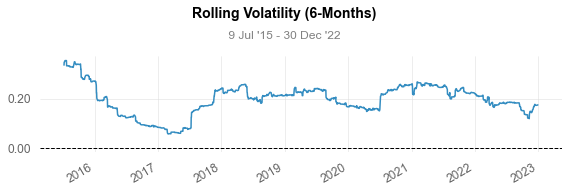

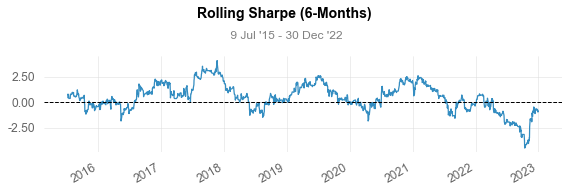

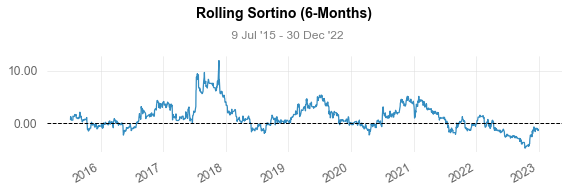

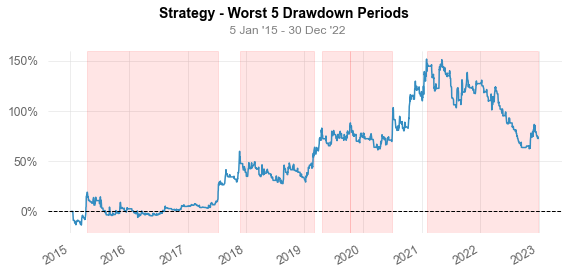

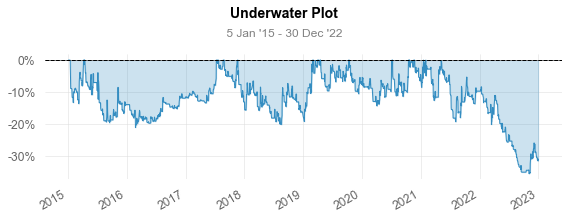

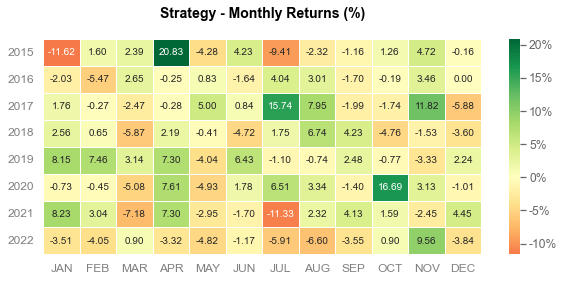

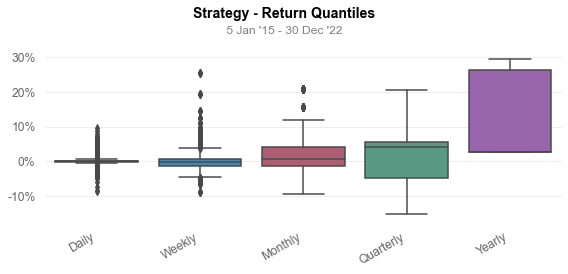

In [8]:
cerebro = bt.Cerebro()


cerebro.adddata(stock_data, name='stock')

start_cash=1000000

cerebro.addstrategy(SmaCross)
# 设置现金
cerebro.broker.setcash(start_cash)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')

print('初始市值: %.2f' % cerebro.broker.getvalue())
results = cerebro.run()
strat = results[0]

portfolio_stats = strat.analyzers.getbyname('PyFolio')
returns, _,_,_ = portfolio_stats.get_pf_items()

returns.index=returns.index.tz_convert(None)
print('最终市值: %.2f' % cerebro.broker.getvalue())
# logger.info(f'================================= 回测结束 {dt.now().strftime("%Y%m%d %H:%M:%S")} =========================================')
qs.reports.full(returns)

## **使用CSV作为数据源**

In [9]:
datapath = '600000qfq.csv'
# df=pd.read_csv(datapath)
# print(df)
data = bt.feeds.GenericCSVData(
        dataname=datapath,
        datetime=2,  # 日期行所在列
        open=3,  # 开盘价所在列
        high=4,  # 最高价所在列
        low=5,  # 最低价所在列
        close=6,  # 收盘价价所在列
        volume=10,  # 成交量所在列
        openinterest=-1,  # 无未平仓量列.(openinterest是期货交易使用的)
        dtformat=('%Y%m%d'),  # 日期格式
        fromdate=dt.strptime(start_date, '%Y%m%d'),  # 起始日
        todate=dt.strptime(end_date, '%Y%m%d'))  # 结束日

初始市值: 1000000.00
最终市值: 944747.26


                           Strategy
-------------------------  ----------
Start Period               2015-01-05
End Period                 2020-07-10
Risk-Free Rate             0.0%
Time in Market             35.0%

Cumulative Return          -5.53%
CAGR﹪                     -0.71%

Sharpe                     0.01
Prob. Sharpe Ratio         50.83%
Smart Sharpe               0.01
Sortino                    0.01
Smart Sortino              0.01
Sortino/√2                 0.01
Smart Sortino/√2           0.01
Omega                      1.0

Max Drawdown               -24.27%
Longest DD Days            961
Volatility (ann.)          15.69%
Calmar                     -0.03
Skew                       -0.51
Kurtosis                   31.56

Expected Daily %           -0.0%
Expected Monthly %         -0.08%
Expected Yearly %          -0.94%
Kelly Criterion            0.16%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.63%
Expected Shortfall (cVaR)  -1.63%

Max Consecutive Wins   

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2017-11-23,2019-05-29,2020-07-10,961,-24.265390,-23.516264
2,2015-01-19,2015-08-05,2015-11-24,310,-22.793456,-21.940718
3,2015-11-26,2016-05-19,2017-05-24,546,-12.068437,-11.565530
4,2017-07-18,2017-10-20,2017-11-21,127,-4.399881,-4.326611
5,2017-05-26,2017-07-11,2017-07-12,48,-2.077181,-1.921089


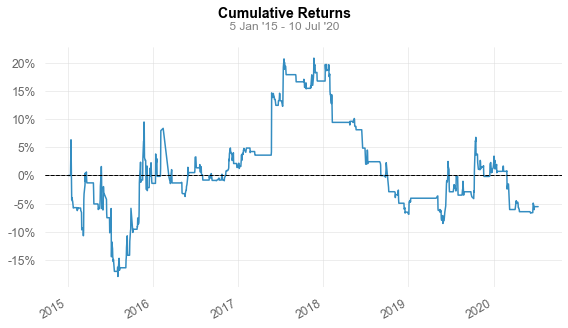

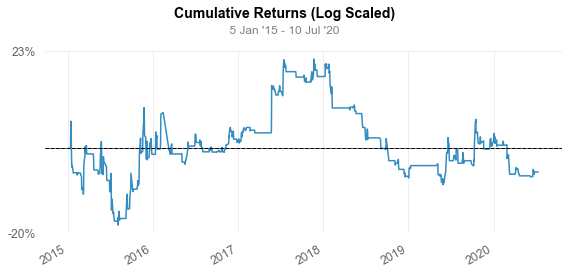

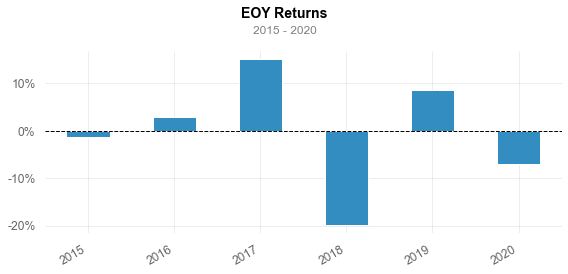

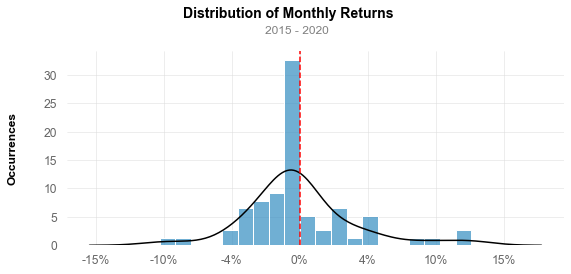

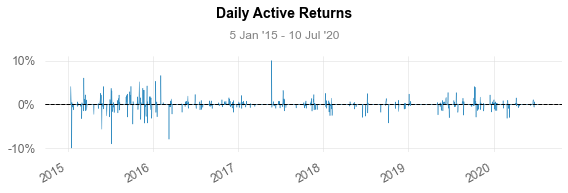

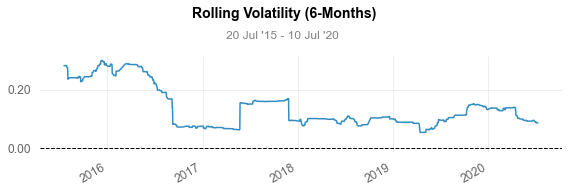

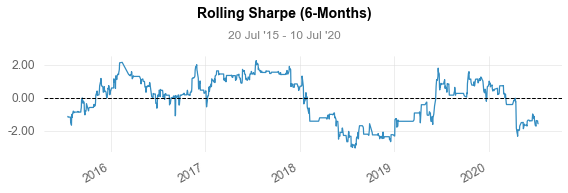

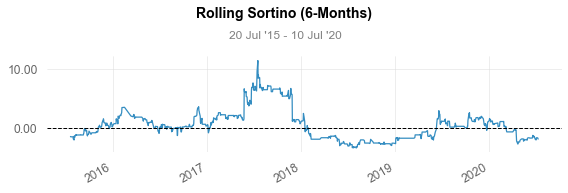

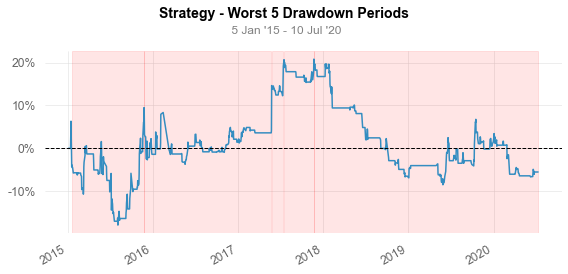

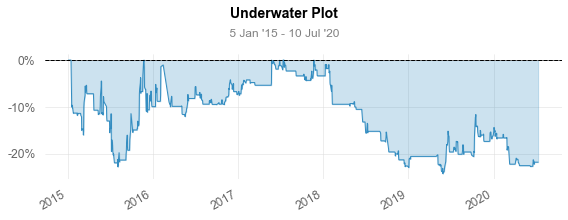

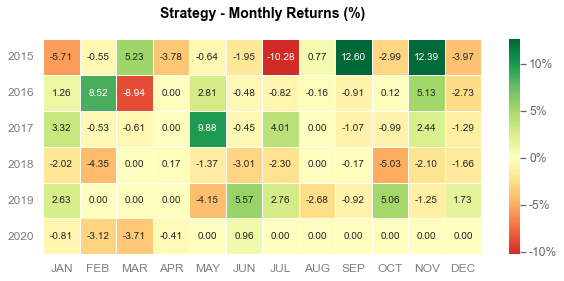

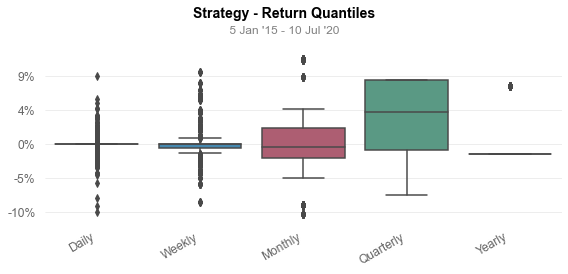

In [10]:
cerebro = bt.Cerebro()


cerebro.adddata(data, name='stock')

start_cash=1000000

cerebro.addstrategy(SmaCross)
# 设置现金
cerebro.broker.setcash(start_cash)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')

print('初始市值: %.2f' % cerebro.broker.getvalue())
results = cerebro.run()
strat = results[0]

portfolio_stats = strat.analyzers.getbyname('PyFolio')
returns, _,_,_ = portfolio_stats.get_pf_items()

returns.index=returns.index.tz_convert(None)
print('最终市值: %.2f' % cerebro.broker.getvalue())
# logger.info(f'================================= 回测结束 {dt.now().strftime("%Y%m%d %H:%M:%S")} =========================================')
qs.reports.full(returns)

## **扩展数据源**
> ### **上面传入的都是标准的行情数据：高开低收+成交量，默认都是这几列数据**

> ### **如果想要传入更多的数据，可以用下面的扩展方式**

In [11]:
stock_zh_a_hist_df = ak.stock_zh_a_hist(symbol=symbol, period="daily", start_date=start_date, end_date=end_date, adjust="hfq")
stock_zh_a_hist_df.rename(columns={'日期':'date','开盘':'open','收盘':'close','最高':'high','最低':'low','成交量':'volume','换手率':'turnover'},inplace=True)
print(stock_zh_a_hist_df.head())
stock_zh_a_hist_df = stock_zh_a_hist_df[['date', 'open', 'high', 'low', 'close', 'volume']]
stock_zh_a_hist_df.date=pd.to_datetime(stock_zh_a_hist_df.date)
# stock_zh_a_hist_df.sort_values(by='date', inplace=True)
stock_zh_a_hist_df

         date     open    close     high      low   volume           成交额  \
0  2015-01-05  1797.18  1800.57  1829.92  1753.17  2860436  4.565388e+09   
1  2015-01-06  1781.38  1773.48  1842.33  1747.52  2166421  3.453446e+09   
2  2015-01-07  1748.65  1739.62  1779.13  1719.31  1700121  2.634796e+09   
3  2015-01-08  1741.88  1680.93  1749.78  1674.16  1407714  2.128003e+09   
4  2015-01-09  1674.16  1694.48  1783.64  1652.72  2508500  3.835378e+09   

     振幅   涨跌幅    涨跌额  turnover  
0  4.31  1.14  20.32      2.91  
1  5.27 -1.50 -27.09      2.20  
2  3.37 -1.91 -33.86      1.73  
3  4.35 -3.37 -58.69      1.43  
4  7.79  0.81  13.55      2.55  


,date,open,high,low,close,volume
0,2015-01-05,1797.18,1829.92,1753.17,1800.57,2860436
1,2015-01-06,1781.38,1842.33,1747.52,1773.48,2166421
2,2015-01-07,1748.65,1779.13,1719.31,1739.62,1700121
3,2015-01-08,1741.88,1749.78,1674.16,1680.93,1407714
4,2015-01-09,1674.16,1783.64,1652.72,1694.48,2508500
...,...,...,...,...,...,...
1942,2022-12-26,2317.14,2325.26,2271.63,2281.38,797120
1943,2022-12-27,2297.63,2354.52,2297.63,2336.64,886004
1944,2022-12-28,2344.77,2380.52,2318.76,2341.52,791192
1945,2022-12-29,2330.14,2339.89,2294.38,2323.64,666890


## **用Pandas来扩展数据**

### **新计算3种指标**

- KAMA15：[考夫曼均线](https://xueqiu.com/6643166607/203027818)
- ma5: 5日均线
- ma5_day3_slope

[talib函数大全](https://www.windquant.com/qntcloud/article?5750f071-4e6e-4922-b007-71db3733835d)

In [12]:
stock_zh_a_hist_df['KAMA15'] = ta.KAMA(stock_zh_a_hist_df.close, timeperiod=15)   
stock_zh_a_hist_df['ma5'] = ta.SMA(stock_zh_a_hist_df['close'], 5)
stock_zh_a_hist_df['ma5_day3_slope'] = ta.LINEARREG_SLOPE(stock_zh_a_hist_df['ma5'], 3)
stock_zh_a_hist_df

,date,open,high,low,close,volume,KAMA15,ma5,ma5_day3_slope
0,2015-01-05,1797.18,1829.92,1753.17,1800.57,2860436,NaN,NaN,NaN
1,2015-01-06,1781.38,1842.33,1747.52,1773.48,2166421,NaN,NaN,NaN
2,2015-01-07,1748.65,1779.13,1719.31,1739.62,1700121,NaN,NaN,NaN
3,2015-01-08,1741.88,1749.78,1674.16,1680.93,1407714,NaN,NaN,NaN
4,2015-01-09,1674.16,1783.64,1652.72,1694.48,2508500,NaN,1737.816,NaN
...,...,...,...,...,...,...,...,...,...
1942,2022-12-26,2317.14,2325.26,2271.63,2281.38,797120,2291.741211,2297.634,-10.239
1943,2022-12-27,2297.63,2354.52,2297.63,2336.64,886004,2292.423402,2309.010,1.300
1944,2022-12-28,2344.77,2380.52,2318.76,2341.52,791192,2292.640500,2317.138,9.752
1945,2022-12-29,2330.14,2339.89,2294.38,2323.64,666890,2293.183334,2319.738,5.364


In [13]:
class PandasData_more(bt.feeds.PandasData):
    lines = ('KAMA15','ma5', 'ma5_day3_slope')  # 要添加的线
    # 设置 line 在数据源上的列位置··········
    params = (
        ('KAMA15', -1),
        ('ma5', -1),
        ('ma5_day3_slope', -1)
    )

In [14]:
data_more = PandasData_more(
                dataname=stock_zh_a_hist_df,
                datetime=0,  # 日期列
                open=1,  # 开盘价所在列
                high=2,  # 最高价所在列
                low=3,  # 最低价所在列
                close=4,  # 收盘价所在列
                volume=5,
    
                KAMA15=6,
                ma5=7,
                ma5_day3_slope=8,
    
                fromdate=dt.strptime(start_date, '%Y%m%d'),  # 起始日  dt.strptime(start, '%Y%m%d')
                todate=dt.strptime(end_date, '%Y%m%d'))

> ### **定义一个新的策略，包含了新的入场指标**

In [17]:
class SmaCrossMore(bt.Strategy):
    
    def __init__(self):
        pass

    def next(self):
        size = int(self.broker.getvalue() / self.datas[0].close // 100 * 100)  # 股数
        
        # 3个入场条件
        cond01 = self.datas[0].close[-1] < self.data.ma5[-1] and self.datas[0].close[0] > self.data.ma5[0]
        cond02 = self.data.ma5_day3_slope > 0
        cond03 = self.datas[0].close[-1] < self.data.KAMA15[-1] and self.data.close > self.data.KAMA15
        
        # 1个离场条件
        cond04 = self.datas[0].close[-1] > self.data.KAMA15[-1] and self.data.close < self.data.KAMA15
        
        if not self.position.size:  # 还没有仓位
            # 入场条件
            if cond01 and cond02 and cond03:
                self.buy(size=size)
        # 离场条件触发
        elif cond04:
            self.close()

初始市值: 1000000.00
最终市值: 1409957.00


                           Strategy
-------------------------  ----------
Start Period               2015-01-05
End Period                 2022-12-30
Risk-Free Rate             0.0%
Time in Market             14.0%

Cumulative Return          41.0%
CAGR﹪                     3.01%

Sharpe                     0.49
Prob. Sharpe Ratio         92.24%
Smart Sharpe               0.46
Sortino                    0.83
Smart Sortino              0.78
Sortino/√2                 0.59
Smart Sortino/√2           0.55
Omega                      1.27

Max Drawdown               -17.93%
Longest DD Days            922
Volatility (ann.)          10.15%
Calmar                     0.17
Skew                       3.28
Kurtosis                   48.22

Expected Daily %           0.02%
Expected Monthly %         0.36%
Expected Yearly %          4.39%
Kelly Criterion            10.81%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.03%
Expected Shortfall (cVaR)  -1.03%

Max Consecutive Wins       

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2017-11-23,2019-01-08,2019-02-22,457,-17.929389,-15.972794
2,2020-08-18,2022-09-08,2022-11-28,833,-14.000249,-13.942372
3,2015-05-04,2016-11-03,2017-11-10,922,-7.183194,-6.792649
4,2022-12-12,2022-12-29,2022-12-30,19,-6.401728,-6.140080
5,2019-03-07,2019-03-25,2019-06-19,105,-6.396473,-5.604926


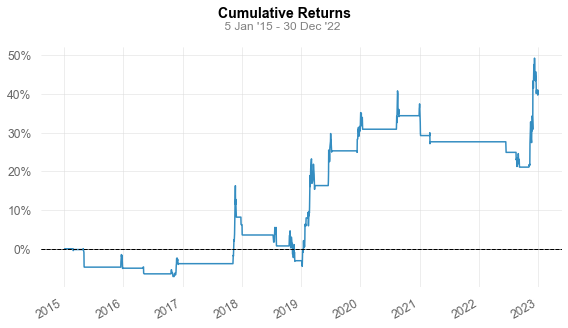

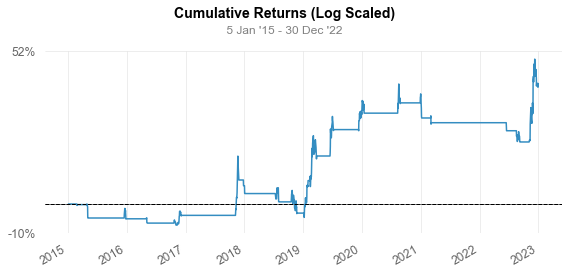

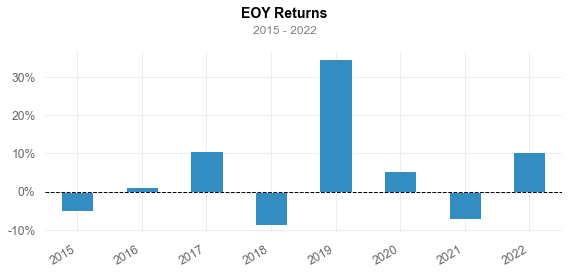

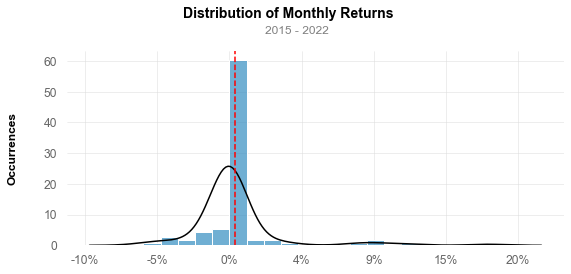

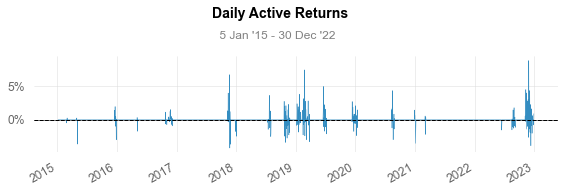

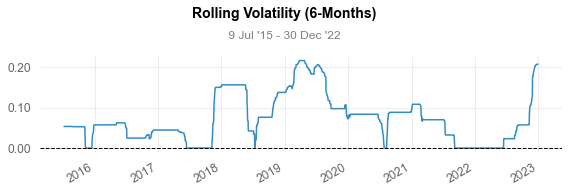

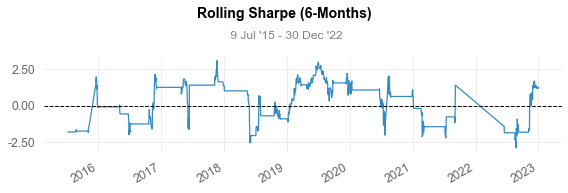

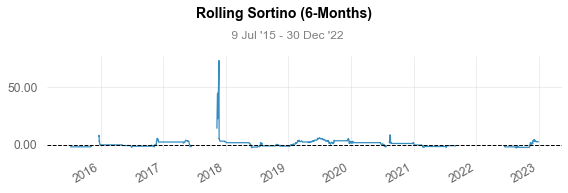

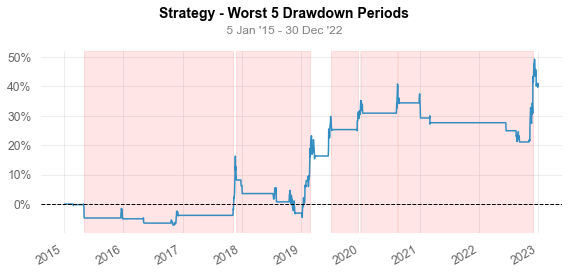

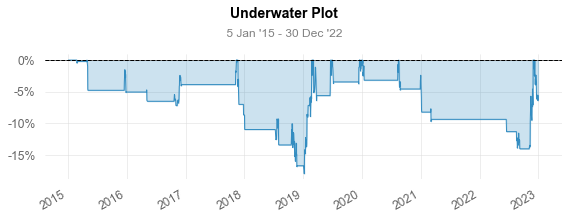

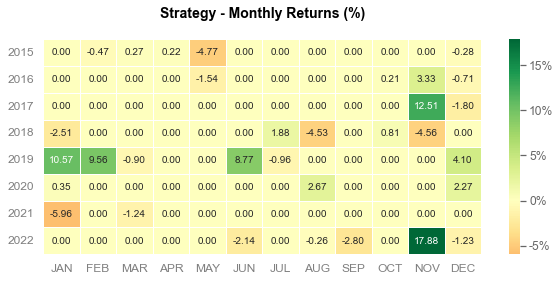

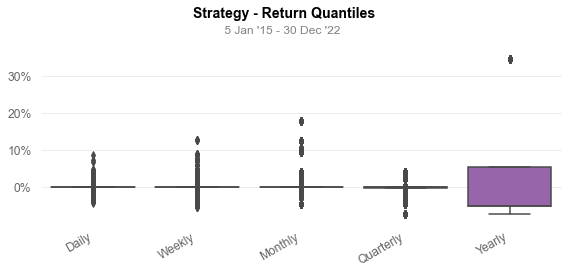

In [18]:
cerebro = bt.Cerebro()


cerebro.adddata(data_more, name='stock')

start_cash=1000000

cerebro.addstrategy(SmaCrossMore)
# 设置现金
cerebro.broker.setcash(start_cash)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')

print('初始市值: %.2f' % cerebro.broker.getvalue())
results = cerebro.run()
strat = results[0]

portfolio_stats = strat.analyzers.getbyname('PyFolio')
returns, _,_,_ = portfolio_stats.get_pf_items()

returns.index=returns.index.tz_convert(None)
print('最终市值: %.2f' % cerebro.broker.getvalue())
# logger.info(f'================================= 回测结束 {dt.now().strftime("%Y%m%d %H:%M:%S")} =========================================')
qs.reports.full(returns)

## **用CSV来扩展数据**

In [19]:
class GenericCSV_PE(GenericCSVData):

    # 增加pe线
    lines = ('pe', )
    # 默认第8列（从0开始数）
    params = (('pe', 8), )

In [21]:
datapath = '600000pe.csv'


data_csv_more = GenericCSV_PE(
    dataname=datapath,
    datetime=2,  # 日期行所在列
    open=3,  # 开盘价所在列
    high=4,  # 最高价所在列
    low=5,  # 最低价所在列
    close=6,  # 收盘价价所在列
    volume=10,  # 成交量所在列
    openinterest=-1,  # 无未平仓量列
    pe=12,  # pe所在列 
    dtformat=('%Y%m%d'),  # 日期格式
    fromdate=dt.strptime(start_date, '%Y%m%d'),  # 起始日
    todate=dt.strptime(end_date, '%Y%m%d'))  # 结束日

#### 注意：这里新介绍一个backtrader内部的指标用法 bt.ind.CrossOver(X, Y), 如果X>Y，返回1，反之返回-1

 >### **定义一个新策略**

In [22]:
class SmaCrossCSVMore(bt.Strategy):
    # 定义参数
    params = dict(period=5  # 移动平均期数
                  )
    # 日志函数
    def log(self, txt, dt=None):
        '''日志函数'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
    def __init__(self):
        # 移动平均线指标
        self.move_average = bt.ind.MovingAverageSimple(
            self.data, period=self.params.period)

        # 交叉信号指标
        self.crossover = bt.ind.CrossOver(self.data, self.move_average)

    def next(self):

        if not self.position:  # 还没有仓位
            # 当日收盘价上穿5日均线，创建买单，买入100股
            if self.crossover > 0 and self.data.pe < 30:
                self.log('创建买单')
                self.buy(size=100)
        # 有仓位，并且当日收盘价下破5日均线，创建卖单，卖出100股
        elif self.crossover < 0:
            self.log('创建卖单')
            self.sell(size=100)

初始市值: 10000.00
2015-01-14, 创建买单
2015-01-19, 创建卖单
2015-01-21, 创建买单
2015-01-26, 创建卖单
2015-02-03, 创建买单
2015-02-04, 创建卖单
2015-02-10, 创建买单
2015-02-16, 创建卖单
2015-02-17, 创建买单
2015-02-25, 创建卖单
2015-02-26, 创建买单
2015-03-03, 创建卖单
2015-03-09, 创建买单
2015-03-24, 创建卖单
2015-03-30, 创建买单
2015-04-20, 创建卖单
2015-04-22, 创建买单
2015-04-23, 创建卖单
2015-04-27, 创建买单
2015-04-30, 创建卖单
2015-05-11, 创建买单
2015-05-13, 创建卖单
2015-05-19, 创建买单
2015-05-28, 创建卖单
2015-06-01, 创建买单
2015-06-18, 创建卖单
2015-06-24, 创建买单
2015-06-25, 创建卖单
2015-06-30, 创建买单
2015-07-01, 创建卖单
2015-07-02, 创建买单
2015-07-03, 创建卖单
2015-07-06, 创建买单
2015-07-08, 创建卖单
2015-07-09, 创建买单
2015-07-14, 创建卖单
2015-07-15, 创建买单
2015-07-16, 创建卖单
2015-07-17, 创建买单
2015-07-20, 创建卖单
2015-08-03, 创建买单
2015-08-06, 创建卖单
2015-08-07, 创建买单
2015-08-12, 创建卖单
2015-08-27, 创建买单
2015-09-07, 创建卖单
2015-09-08, 创建买单
2015-09-15, 创建卖单
2015-09-24, 创建买单
2015-10-08, 创建卖单
2015-10-26, 创建买单
2015-11-11, 创建卖单
2015-11-19, 创建买单
2015-11-27, 创建卖单
2015-12-02, 创建买单
2015-12-04, 创建卖单
2015-12-07, 创建买单
2015-12-09, 创建卖单

                           Strategy
-------------------------  ----------
Start Period               2015-01-05
End Period                 2020-07-10
Risk-Free Rate             0.0%
Time in Market             61.0%

Cumulative Return          -17.33%
CAGR﹪                     -2.35%

Sharpe                     -1.54
Prob. Sharpe Ratio         0.04%
Smart Sharpe               -1.42
Sortino                    -2.13
Smart Sortino              -1.97
Sortino/√2                 -1.5
Smart Sortino/√2           -1.39
Omega                      0.68

Max Drawdown               -18.8%
Longest DD Days            2000
Volatility (ann.)          2.36%
Calmar                     -0.13
Skew                       0.74
Kurtosis                   16.92

Expected Daily %           -0.01%
Expected Monthly %         -0.28%
Expected Yearly %          -3.12%
Kelly Criterion            -17.19%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.26%
Expected Shortfall (cVaR)  -0.26%

Max Consecutive 

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2015-01-19,2020-06-29,2020-07-10,2000,-18.79712,-18.553245


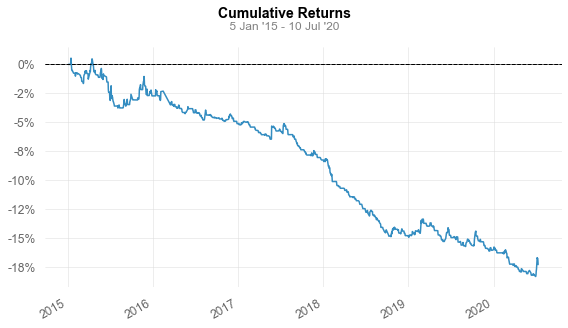

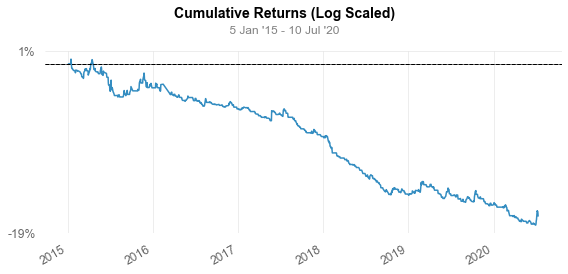

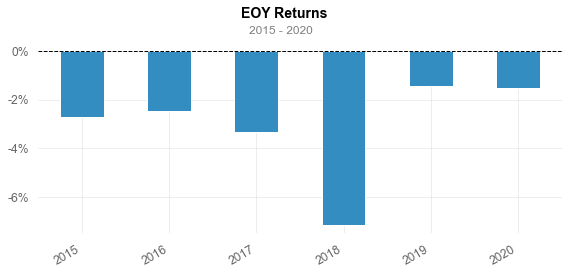

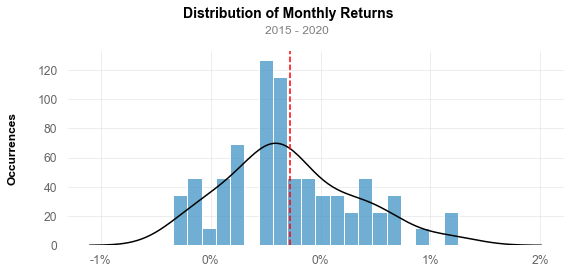

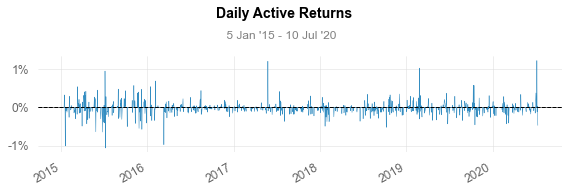

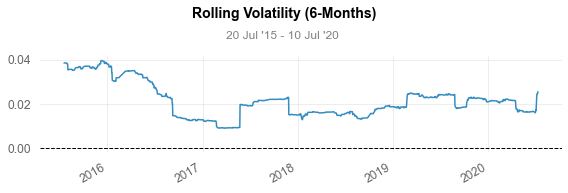

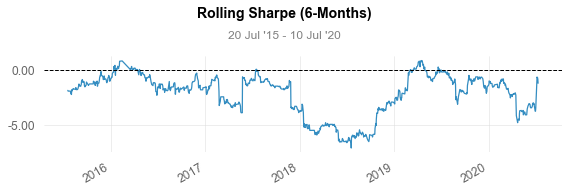

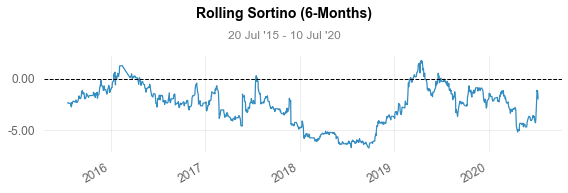

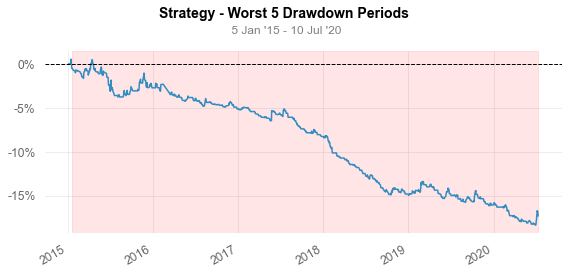

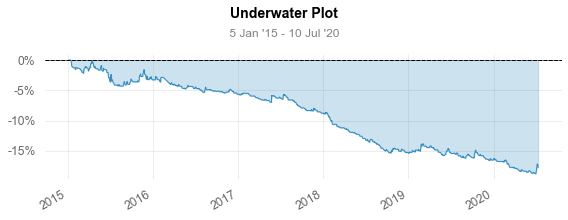

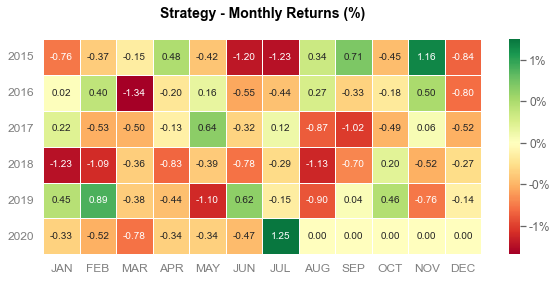

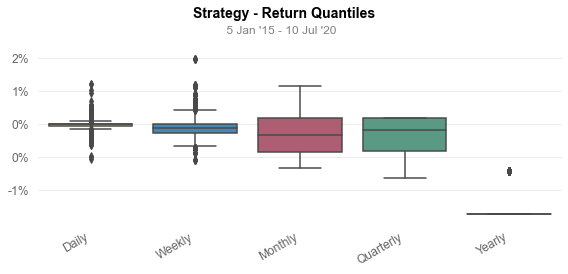

In [23]:
cerebro = bt.Cerebro()


cerebro.adddata(data_csv_more)  # 将行情数据对象注入引擎
cerebro.addstrategy(SmaCrossCSVMore)  # 将策略注入引擎

cerebro.broker.setcash(10000.0)  # 设置初始资金
cerebro.broker.setcommission(0.001)  # 佣金费率
# 固定滑点，也可用cerebro.broker.set_slippage_perc()设置百分比滑点
cerebro.broker.set_slippage_fixed(0.05)

cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')
print('初始市值: %.2f' % cerebro.broker.getvalue())
results = cerebro.run()
strat = results[0]

portfolio_stats = strat.analyzers.getbyname('PyFolio')
returns, _,_,_ = portfolio_stats.get_pf_items()

returns.index=returns.index.tz_convert(None)
print('最终市值: %.2f' % cerebro.broker.getvalue())
# logger.info(f'================================= 回测结束 {dt.now().strftime("%Y%m%d %H:%M:%S")} =========================================')
qs.reports.full(returns)